# A primer on Pipelines and Gridsearch

## This tutorial was entirely [stolen](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).


## Before we get started...

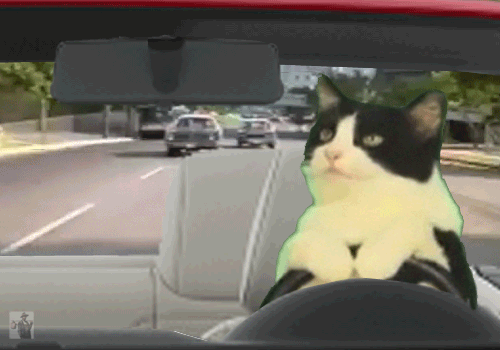

In [327]:
from IPython.display import display, Image
with open('11fucLQCTOdvBS.gif','rb') as f:
    display(Image(f.read(), width=800), format='png')

This talk ...
* ... will be technically
* ... assumes familiarity with Python
* ... requires a fundamental understanding of machine learning and text processing
* ... will have a strong tutorial-like flavor


# What's this talk about?

## Part 0
* What are Pipelines and Gridsearch?
* Why should I care?

## Part 1 (optional)
* Custom pipeline

# Part 0

# A typical Text Processing Application

#### There is some text + labels to begin with

In [328]:
from sklearn.datasets import fetch_20newsgroups

twenty_train = fetch_20newsgroups(subset='train', shuffle=True, 
                                  random_state=42)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True, 
                                 random_state=42)

len(twenty_train.data), len(twenty_test.data)

(11314, 7532)

# Let's have a closer look at the data

In [331]:
idx = 42
print('category: {}'.format(
        twenty_test.target_names[twenty_test.target[idx]])
     )

category: rec.motorcycles


In [332]:
print(twenty_test.data[idx])

From: egreen@east.sun.com (Ed Green - Pixel Cruncher)
Subject: Re: A Point for Helmet Law is a Point for
Organization: Sun Microsystems, RTP, NC
Lines: 20
Distribution: world
Reply-To: egreen@east.sun.com
NNTP-Posting-Host: laser.east.sun.com

In article i8n@agate.berkeley.edu, manish@uclink.berkeley.edu (Manish Vij) writes:
>
>>Motorcycles are not allowed on th 17 mile drive at pebble Beach.
>
>what?
>
>are there posted signs?
>
>what do they cite you for?

They don't.  It's a closed access road, you pay to get in (if you don't
have a resident sticker), and they simply don't open the gates if
you're on a bike.

---
Ed Green, former Ninjaite |I was drinking last night with a biker,
  Ed.Green@East.Sun.COM   |and I showed him a picture of you.  I said,
DoD #0111  (919)460-8302  |"Go on, get to know her, you'll like her!"
 (The Grateful Dead) -->  |It seemed like the least I could do...




# Feature extraction
#### Bag of words is our friend

In [333]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(11314, 130107)

In [334]:
X_train_counts[0, :]

<1x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 89 stored elements in Compressed Sparse Row format>

In [335]:
len(twenty_train.data[0].split())

123

#### The count vectorizer also remembers the frequency of words...

In [338]:
count_vect.vocabulary_.get('einstein')

50856

# TF/IDF is even better
#### (document length is no issue)

In [339]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11314, 130107)

# SVM to our help!

In [340]:
from sklearn.linear_model import SGDClassifier # Here I am

#### Training

In [341]:
clf = SGDClassifier().fit(X_train_tfidf, twenty_train.target)

#### Prediction

In [342]:
docs_new = ['Dot product on normalized vectors is equal to cosine similarity', 
            'I love the new Ford Mustang']

X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('"{}" => {}'.format(doc, twenty_train.target_names[category]))

"Dot product on normalized vectors is equal to cosine similarity" => comp.graphics
"I love the new Ford Mustang" => rec.autos


# So that's what your work might look like  
_ _
#### It's a toy example, but do you remember all the details?

#### What was the name of the BOW-Transformer?

#### `count_transformer`?

#### `count_vectorizer`?

#### `count_vect`?

# `<Pipeline>`
A Pipeline consists of zero or more __transformers__ followed by one __estimator__.

# An sklearn flavored Pipeline

#### The pipeline

In [343]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier()),
])

#### Training

In [344]:
text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

#### Predicting

In [345]:
predicted = text_clf.predict(docs_new)

for doc, category in zip(docs_new, predicted):
    print('"{}" => {}'.format(doc, twenty_train.target_names[category]))

"Dot product on normalized vectors is equal to cosine similarity" => comp.graphics
"I love the new Ford Mustang" => rec.autos


# `</Pipeline>`

# `<Gridsearch>`
GridsearchCV helps you finding good hyper parameter for your pipeline.

#### First, how are we doing on the test set?

In [346]:
import numpy as np

predicted = text_clf.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.85090281465746154

__85%__! Not too bad.  
But there are some parameters to tune. Maybe we can do better.

## Which parameters do we want to test for?

In [ ]:
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}

That's all we need for a Gridsearch!

In [347]:
from sklearn.model_selection import GridSearchCV

gs_clf = GridSearchCV(text_clf, parameters, verbose=1, n_jobs=72)

The following takes some time

In [348]:
gs_clf = gs_clf.fit(twenty_train.data, twenty_train.target)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=72)]: Done   6 out of  24 | elapsed:    8.1s remaining:   24.4s
[Parallel(n_jobs=72)]: Done  24 out of  24 | elapsed:   28.2s finished


__Note:__ This one includes cross-validation.

In [349]:
predicted = gs_clf.predict(docs_new)

for doc, category in zip(docs_new, predicted):
    print('"{}" => {}'.format(doc, twenty_train.target_names[category]))

"Dot product on normalized vectors is equal to cosine similarity" => comp.windows.x
"I love the new Ford Mustang" => rec.autos


In [350]:
gs_clf.best_score_

0.89915149372458902

In [351]:
gs_clf.best_params_

{'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

# Detailed reports

In [353]:
gs_clf.cv_results_['mean_test_score']

{'mean_fit_time': array([  3.40501897,  14.49964849,   3.42794601,  14.8985792 ,
          3.42136876,  15.219956  ,   3.39598211,  14.8672088 ]),
 'mean_score_time': array([ 1.34609612,  3.35005474,  1.30508606,  3.46768339,  1.3065416 ,
         3.48560437,  1.26843055,  3.36135817]),
 'mean_test_score': array([ 0.87793884,  0.89835602,  0.67677214,  0.68985328,  0.88394909,
         0.89915149,  0.822344  ,  0.84726887]),
 'mean_train_score': array([ 0.97122993,  0.99253124,  0.7600314 ,  0.80970092,  0.97534004,
         0.99284065,  0.92451804,  0.96628054]),
 'param_clf__alpha': masked_array(data = [0.01 0.01 0.01 0.01 0.001 0.001 0.001 0.001],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_tfidf__use_idf': masked_array(data = [True True False False True True False False],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_vect__ngram_range': masked_array(data = [(1, 1)

# Free beer (1/2)

In [354]:
from sklearn import metrics
predicted = gs_clf.predict(twenty_test.data)

In [355]:
print(metrics.classification_report(twenty_test.target, predicted, 
        target_names=twenty_test.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.75      0.76      0.75       319
           comp.graphics       0.80      0.70      0.75       389
 comp.os.ms-windows.misc       0.74      0.79      0.77       394
comp.sys.ibm.pc.hardware       0.76      0.69      0.73       392
   comp.sys.mac.hardware       0.86      0.82      0.84       385
          comp.windows.x       0.85      0.77      0.81       395
            misc.forsale       0.84      0.91      0.87       390
               rec.autos       0.95      0.89      0.92       396
         rec.motorcycles       0.92      0.97      0.94       398
      rec.sport.baseball       0.91      0.91      0.91       397
        rec.sport.hockey       0.87      0.99      0.93       399
               sci.crypt       0.80      0.96      0.87       396
         sci.electronics       0.86      0.65      0.74       393
                 sci.med       0.86      0.85      0.85       396
         

# Free beer (2/2)

In [356]:
metrics.confusion_matrix(twenty_test.target, predicted)[:10, :10]

array([[243,   0,   0,   3,   0,   2,   0,   0,   0,   1],
       [  4, 274,  24,   8,   8,  23,   4,   0,   2,   5],
       [  2,  10, 313,  19,   5,  10,   1,   0,   1,   6],
       [  3,  11,  26, 272,  18,   3,  12,   4,   4,   1],
       [  2,   3,   7,  18, 315,   2,   9,   2,   2,   3],
       [  1,  27,  38,   2,   3, 305,   2,   0,   2,   1],
       [  0,   2,   1,  12,   3,   0, 354,   3,   1,   2],
       [  3,   1,   0,   4,   0,   2,  11, 353,   6,   1],
       [  0,   0,   0,   1,   0,   0,   4,   3, 387,   0],
       [  0,   0,   1,   0,   1,   0,   4,   0,   0, 360]])

# `</Gridsearch>`

# Wrap-up

# Why Pipeline?

* Abstraction of details
    * Easier to get into the head
        * Easier to read and alter
        * Easier to reason about    
* Increases reuseablity
* Provides unified interface for very different Pipelines
* Enables `GridsearchCV`

# Why Gridsearch?

* Semi-automatic hyperparameter search
* Built-in parallelism
* Built-in Cross-Validation
* Convenient interface

__Note:__ There is also a better scaling version of this called `RandomizedSearchCV`.

# Part 1

# A custom pipeline

A __transformer__ must implement:
* a __`fit`__ method with two parameters (data and label) which returns itself. (label is optional).
* a __`transform`__ method with one parameter returning an altered version of that parameter.

In [357]:
class foo():
    def fit(self, X, y=None):
        print('foo.fit entered.\nX: {}, y: {}\n'.format(X, y))
        return self
    
    def transform(self, X):
        print('foo.transform entered.\nX: {}\n'.format(X))
        return X + 'o'
    
class bar():
    def fit(self, X, y=None):
        print('bar.fit entered.\nX: {}, y: {}\n'.format(X, y))
        return self
    
    def transform(self, X):
        print('bar.transform entered.\nX: {}\n'.format(X))
        return X + 'a'

An __estimator__ must implement:
* a __`fit`__ method with two parameters (data and label) which returns itself. (label is optional).
* a __`predict`__ method with one parameter returning the predicted label.

In [358]:
class grok():
    def fit(self, X, y):
        print('grok.fit entered.\nX: {}, y: {}\n'.format(X, y))
        return self
    def predict(self, X):
        print('grok.predict entered.\nX: {}\n'.format(X))
        return X + 'u'

# This is sufficient to construct a Pipeline

In [359]:
pipe = Pipeline([
        ('foo', foo()),
        ('bar', bar()),
        ('grok', grok()),
    ])

### The supervised case

In [360]:
pipe.fit("foo", "bar")

foo.fit entered.
X: foo, y: bar

foo.transform entered.
X: foo

bar.fit entered.
X: fooo, y: bar

bar.transform entered.
X: fooo

grok.fit entered.
X: foooa, y: bar



Pipeline(steps=[('foo', <__main__.foo object at 0x7f7dfec85828>), ('bar', <__main__.bar object at 0x7f7dfec85860>), ('grok', <__main__.grok object at 0x7f7dfec85518>)])

### The unsupervised case

In [361]:
pipe.fit('foo')

foo.fit entered.
X: foo, y: None

foo.transform entered.
X: foo

bar.fit entered.
X: fooo, y: None

bar.transform entered.
X: fooo

grok.fit entered.
X: foooa, y: None



Pipeline(steps=[('foo', <__main__.foo object at 0x7f7dfec85828>), ('bar', <__main__.bar object at 0x7f7dfec85860>), ('grok', <__main__.grok object at 0x7f7dfec85518>)])

In [362]:
pipe.predict('foobar')

foo.transform entered.
X: foobar

bar.transform entered.
X: foobaro

grok.predict entered.
X: foobaroa



'foobaroau'

# Wrap-up

# Why a custom pipeline?

* Again, reusability!
* Free beer once sklearn compatible
* Once adopted, its a powerful mindset

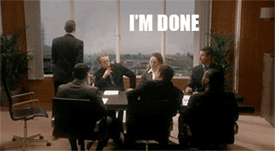

In [363]:
from IPython.display import display, Image
with open('3XiQswSmbjBiU.gif','rb') as f:
    display(Image(f.read(), width=800), format='png')